In [20]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [21]:
# Common parameters
S0 = 100       # Current stock price
K = 105        # Strike price
T = 0.25       # Time to maturity in years (3 months)
r = 0.01       # Risk-free rate
sigma = 0.2    # Volatility
n_simulations = 100000

np.random.seed(42)  # reproducibility

In [22]:
# Simulate stock prices at maturity
Z = np.random.randn(n_simulations)
ST = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma * np.sqrt(T) * Z)

# Call option payoff
payoffs = np.maximum(ST - K, 0)

# Discount back
C_MC = np.exp(-r*T) * np.mean(payoffs)
print(f"Monte Carlo price: {C_MC:.2f}")


Monte Carlo price: 2.15


In [23]:
d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

C_BS = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
print(f"Black–Scholes price: {C_BS:.2f}")


Black–Scholes price: 2.14


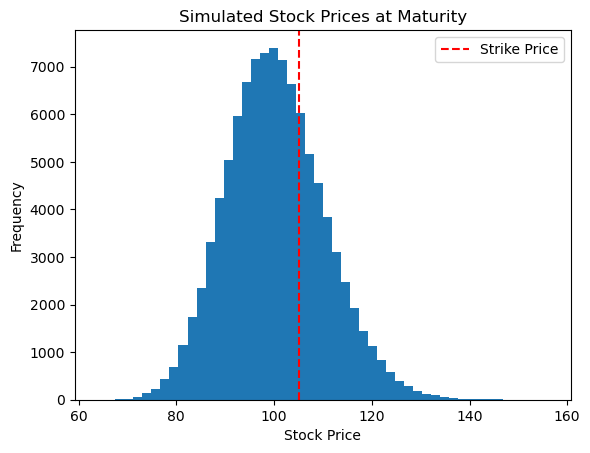

In [24]:
plt.hist(ST, bins=50)
plt.axvline(K, color='red', linestyle='--', label='Strike Price')
plt.title("Simulated Stock Prices at Maturity")
plt.xlabel("Stock Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Interpretation:
# Most simulated stock prices fall below the strike (K),
# meaning many paths expire worthless.
# The right tail shows scenarios where the option pays off.


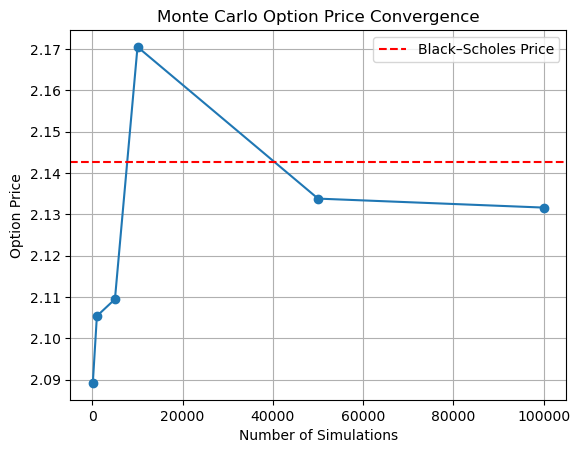

In [25]:
sim_counts = [100, 1000, 5000, 10000, 50000, 100000]
mc_prices = []

for N in sim_counts:
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.randn(N))
    payoff = np.maximum(ST - K, 0)
    price = np.exp(-r*T) * np.mean(payoff)
    mc_prices.append(price)

plt.plot(sim_counts, mc_prices, marker='o')
plt.axhline(C_BS, color='red', linestyle='--', label="Black–Scholes Price")
plt.title("Monte Carlo Option Price Convergence")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo Convergence:
# Shows how the estimated call option price stabilises as the number of simulations increases.
# The plot demonstrates that with more simulations, the Monte Carlo price converges near
# the Black–Scholes benchmark, highlighting the reliability of the simulation.


In [26]:
from scipy.stats import norm
import numpy as np

# -----------------------------
# Black–Scholes Call Option Price
# -----------------------------
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the price of a European call option using the Black–Scholes formula.
    
    Parameters:
    S     : Current stock price
    K     : Strike price
    T     : Time to maturity (in years)
    r     : Risk-free interest rate
    sigma : Volatility of the underlying stock
    
    Returns:
    Call option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


# -----------------------------
# Delta (Δ)
# -----------------------------
def compute_delta(S, K, T, r, sigma, eps=0.01):
    """
    Computes Delta: sensitivity of call price to a small change in underlying stock price.
    
    Parameters:
    eps : small change applied to stock price for numerical approximation
    
    Returns:
    Delta value
    """
    C_plus = black_scholes_call(S + eps, K, T, r, sigma)
    C_minus = black_scholes_call(S - eps, K, T, r, sigma)
    delta = (C_plus - C_minus) / (2 * eps)
    return delta


# -----------------------------
# Vega (ν)
# -----------------------------
def compute_vega(S, K, T, r, sigma, eps=0.01):
    """
    Computes Vega: sensitivity of call price to a small change in volatility.
    
    Parameters:
    eps : small change applied to volatility for numerical approximation
    
    Returns:
    Vega value
    """
    C_plus = black_scholes_call(S, K, T, r, sigma + eps)
    C_minus = black_scholes_call(S, K, T, r, sigma - eps)
    vega = (C_plus - C_minus) / (2 * eps)
    return vega


# -----------------------------
# Theta (Θ)
# -----------------------------
def compute_theta(S, K, T, r, sigma, eps=1/365):
    """
    Computes Theta: sensitivity of call price to the passage of time (time decay).
    
    Parameters:
    eps : small time step in years (default 1 day) for numerical approximation
    
    Returns:
    Theta value
    """
    C_today = black_scholes_call(S, K, T, r, sigma)
    C_tomorrow = black_scholes_call(S, K, T - eps, r, sigma)
    theta = (C_tomorrow - C_today) / eps
    return theta


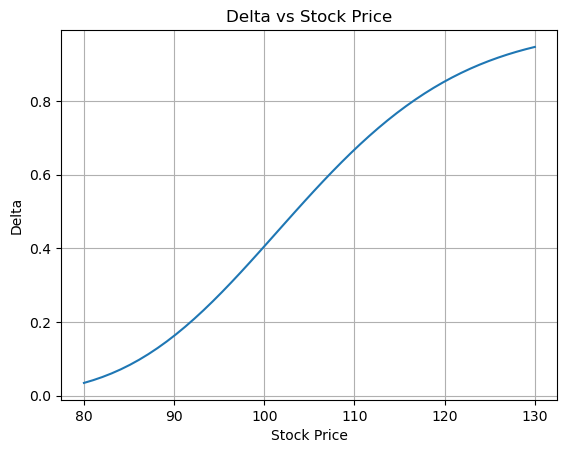

In [27]:
S_range = np.linspace(80, 130, 50)
delta_values = [compute_delta(S, K=K, T=0.5, r=0.01, sigma=0.2) for S in S_range]

plt.plot(S_range, delta_values)
plt.title("Delta vs Stock Price")
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.grid(True)
plt.show()

# Interpretation:
# As S increases, Delta → 1, meaning the option behaves more like the stock itself.


In [28]:
sigma_vals = np.linspace(0.1, 1.0, 10)
vega_results = []

for sigma in sigma_vals:
    price = black_scholes_call(S=100, K=105, T=0.5, r=0.01, sigma=sigma)
    vega = compute_vega(S=100, K=105, T=0.5, r=0.01, sigma=sigma)
    vega_results.append((sigma, price, vega))

vega_df = pd.DataFrame(vega_results, columns=["Volatility", "Call Price", "Vega"])
display(vega_df)

# Vega rises as volatility increases, peaking around moderate levels, showing maximum sensitivity to uncertainty.


,Volatility,Call Price,Vega
0,0.1,1.180914,23.747610
1,0.2,3.798807,27.412385
2,0.3,6.580534,28.067045
3,0.4,9.396432,28.206676
4,0.5,12.216248,28.169862
5,0.6,15.027469,28.042551
6,0.7,17.822787,27.854985
7,0.8,20.596920,27.620397
8,0.9,23.345545,27.345680
9,1.0,26.064872,27.035033


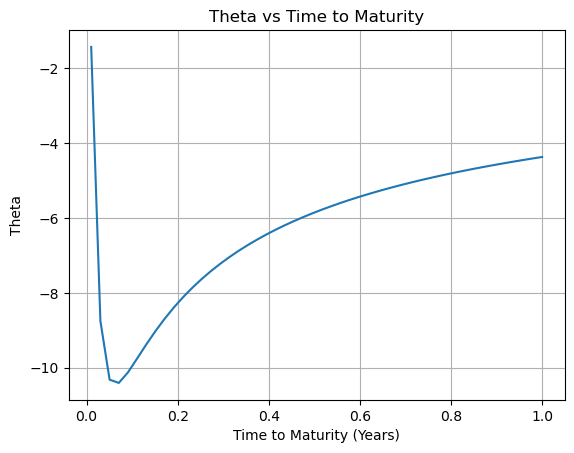

In [29]:
T_range = np.linspace(0.01, 1, 50)  # from ~1 day to 1 year
theta_values = [compute_theta(S=100, K=105, T=t, r=0.01, sigma=0.2) for t in T_range]

plt.plot(T_range, theta_values)
plt.title("Theta vs Time to Maturity")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Theta")
plt.grid(True)
plt.show()

# Interpretation:
# Sharp negative values near expiry show rapid time decay (loss of extrinsic value).
# The curve flattens as maturity approaches.
